In [32]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import os
import sys
import requests
from operator import add

from pyspark import SparkConf,SparkContext
from pyspark.streaming import StreamingContext

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

from pyspark.sql.types import *
from pyspark.sql import functions as func
from pyspark.sql.functions import *

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


# Load the Data

In [34]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CS_777_Final_Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS_777_Final_Project


In [37]:
Meter_Transaction = sqlContext.read.format('csv').options(header='true', inferSchema='true',  sep =",").load("/content/drive/MyDrive/CS_777_Final_Project/Paid_Parking_Transaction_Data-2.csv")

In [38]:
Meter_Transaction.show()

+--------------+----------+--------------------+------------+-----------+-------------------+--------------------+--------------+-----------+--------------------+-----------+-------------+
|Transaction ID|Meter Code|Transaction DateTime|Payment Mean|Amount Paid|Duration In Minutes|      Blockface Name|Side Of Street|Element key|Parking Space Number|   Latitude|    Longitude|
+--------------+----------+--------------------+------------+-----------+-------------------+--------------------+--------------+-----------+--------------------+-----------+-------------+
|    1131346489|  10290004|08/01/2022 07:18:...|       PHONE|       0.65|                 78|VINE ST BETWEEN 3...|            SE|      81290|                null|  47.616859|-122.34744013|
|    1131346494|   1034302|08/01/2022 07:18:...| CREDIT CARD|        1.0|                120|1ST AVE S BETWEEN...|             W|      69081|                null| 47.5996247|-122.33428782|
|    1131327056|   8136002|08/01/2022 04:03:...| CREDIT

In [39]:
Meter_Transaction.count()

131187

# Cleaning

In [40]:
Meter_Transaction_Cleaned = Meter_Transaction.select(col("Transaction ID").alias("Transaction_ID"), col("Meter Code").alias("Meter_Code"), col("Transaction DateTime").alias("Transaction_DateTime"), col("Payment Mean").alias("Payment_Mean"), col("Amount Paid").alias("Amount_Paid"), col("Duration In Minutes").alias("Duration_In_Minutes"), col("Blockface Name").alias("Blockface_Name"), col("Side Of Street").alias("Side_Of_Street"), col("Element Key").alias("Element Key"),
                                                         col("Parking Space Number").alias("Parking_Space_Number"))

In [41]:
Meter_Transaction_Cleaned.show()

+--------------+----------+--------------------+------------+-----------+-------------------+--------------------+--------------+-----------+--------------------+
|Transaction_ID|Meter_Code|Transaction_DateTime|Payment_Mean|Amount_Paid|Duration_In_Minutes|      Blockface_Name|Side_Of_Street|Element Key|Parking_Space_Number|
+--------------+----------+--------------------+------------+-----------+-------------------+--------------------+--------------+-----------+--------------------+
|    1131346489|  10290004|08/01/2022 07:18:...|       PHONE|       0.65|                 78|VINE ST BETWEEN 3...|            SE|      81290|                null|
|    1131346494|   1034302|08/01/2022 07:18:...| CREDIT CARD|        1.0|                120|1ST AVE S BETWEEN...|             W|      69081|                null|
|    1131327056|   8136002|08/01/2022 04:03:...| CREDIT CARD|        4.0|                120|7TH AVE BETWEEN C...|            NE|       8242|                null|
|    1131327142|  1035

In [42]:
# For the purpose of this analysis we would only be looking at pure payments
Meter_Transaction_Cleaned = Meter_Transaction_Cleaned.where(Meter_Transaction_Cleaned.Payment_Mean != "MIXED")

# Getting rid of invalid rows
Meter_Transaction_Cleaned = Meter_Transaction_Cleaned.where(Meter_Transaction_Cleaned.Amount_Paid > 0)
Meter_Transaction_Cleaned = Meter_Transaction_Cleaned.where(Meter_Transaction_Cleaned.Amount_Paid > 0)

In [43]:
Meter_Transaction_Cleaned.show()

+--------------+----------+--------------------+------------+-----------+-------------------+--------------------+--------------+-----------+--------------------+
|Transaction_ID|Meter_Code|Transaction_DateTime|Payment_Mean|Amount_Paid|Duration_In_Minutes|      Blockface_Name|Side_Of_Street|Element Key|Parking_Space_Number|
+--------------+----------+--------------------+------------+-----------+-------------------+--------------------+--------------+-----------+--------------------+
|    1131346489|  10290004|08/01/2022 07:18:...|       PHONE|       0.65|                 78|VINE ST BETWEEN 3...|            SE|      81290|                null|
|    1131346494|   1034302|08/01/2022 07:18:...| CREDIT CARD|        1.0|                120|1ST AVE S BETWEEN...|             W|      69081|                null|
|    1131327056|   8136002|08/01/2022 04:03:...| CREDIT CARD|        4.0|                120|7TH AVE BETWEEN C...|            NE|       8242|                null|
|    1131327142|  1035

# Exploration

In [44]:
grouped_Meter_Transaction = Meter_Transaction_Cleaned.groupBy('Payment_Mean').count().sort(desc("count"))
grouped_Meter_Transaction.show()

+------------+-----+
|Payment_Mean|count|
+------------+-----+
|       PHONE|92289|
| CREDIT CARD|35078|
|        CASH| 3732|
+------------+-----+



In [45]:
grouped_Meter_Transcation_Stats = Meter_Transaction_Cleaned.groupBy(
    "Payment_Mean"
).agg(
    func.sum(func.col("Amount_Paid")).alias("Total_Amount_Paid"),
    func.sum(func.col("Duration_In_Minutes")).alias("Total_Duration_In_Minutes"),
    func.avg(func.col("Amount_Paid")).alias("Average_Amount_Paid"),
    func.avg(func.col("Duration_In_Minutes")).alias("Average_Duration_In_Minutes"),
)

grouped_Meter_Transcation_Stats.show()

+------------+------------------+-------------------------+-------------------+---------------------------+
|Payment_Mean| Total_Amount_Paid|Total_Duration_In_Minutes|Average_Amount_Paid|Average_Duration_In_Minutes|
+------------+------------------+-------------------------+-------------------+---------------------------+
|        CASH| 5333.000000000002|                   230273| 1.4289924973204722|         61.702304394426584|
| CREDIT CARD|          96752.22|                  3708938|  2.758202292034894|         105.73402132390672|
|       PHONE|222552.85000000097|                  8473762| 2.4114775325336817|          91.81768141381963|
+------------+------------------+-------------------------+-------------------+---------------------------+



# Perform Analysis

In [46]:
Meter_Transaction_Analysis = Meter_Transaction_Cleaned.select("Payment_Mean", "Amount_Paid", "Duration_In_Minutes")

In [47]:
Meter_Transaction_Analysis.show()

+------------+-----------+-------------------+
|Payment_Mean|Amount_Paid|Duration_In_Minutes|
+------------+-----------+-------------------+
|       PHONE|       0.65|                 78|
| CREDIT CARD|        1.0|                120|
| CREDIT CARD|        4.0|                120|
|       PHONE|        3.0|                240|
| CREDIT CARD|        6.5|                240|
|       PHONE|       0.28|                 34|
| CREDIT CARD|        1.0|                120|
|       PHONE|       7.25|                350|
|       PHONE|       6.03|                301|
| CREDIT CARD|        1.0|                120|
|       PHONE|       6.43|                317|
|       PHONE|       6.58|                323|
| CREDIT CARD|        9.0|                420|
|       PHONE|       9.43|                328|
|       PHONE|       8.23|                389|
|       PHONE|       6.88|                395|
|       PHONE|        8.4|                396|
| CREDIT CARD|       0.75|                 22|
|       PHONE

In [48]:
Meter_Transaction_Analysis = Meter_Transaction_Analysis.withColumn("Payment_Mean", when(Meter_Transaction_Analysis.Payment_Mean == "CASH", 0).when(Meter_Transaction_Analysis.Payment_Mean == "CREDIT CARD", 1).otherwise(2))
Meter_Transaction_Analysis.show()

+------------+-----------+-------------------+
|Payment_Mean|Amount_Paid|Duration_In_Minutes|
+------------+-----------+-------------------+
|           2|       0.65|                 78|
|           1|        1.0|                120|
|           1|        4.0|                120|
|           2|        3.0|                240|
|           1|        6.5|                240|
|           2|       0.28|                 34|
|           1|        1.0|                120|
|           2|       7.25|                350|
|           2|       6.03|                301|
|           1|        1.0|                120|
|           2|       6.43|                317|
|           2|       6.58|                323|
|           1|        9.0|                420|
|           2|       9.43|                328|
|           2|       8.23|                389|
|           2|       6.88|                395|
|           2|        8.4|                396|
|           1|       0.75|                 22|
|           2

In [49]:
import matplotlib.pyplot as plt

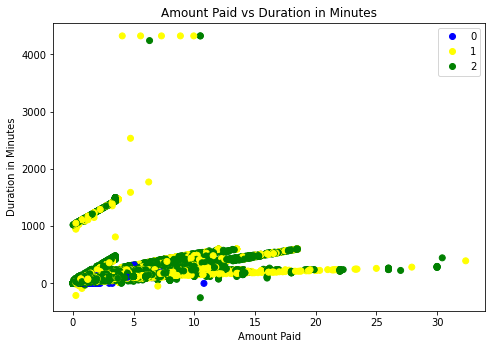

In [50]:
Meter_Transaction_Analysis_Pandas = Meter_Transaction_Analysis.toPandas()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

mydict = {0: 'blue',
          1: 'yellow',
          2: 'green'}

legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(mydict.values())]

ax.scatter(Meter_Transaction_Analysis_Pandas['Amount_Paid'], Meter_Transaction_Analysis_Pandas['Duration_In_Minutes'], c = Meter_Transaction_Analysis_Pandas['Payment_Mean'].map(mydict))
ax.set_xlabel('Amount Paid')
ax.set_ylabel('Duration in Minutes')
ax.set_title('Scatter Plot')
plt.title('Amount Paid vs Duration in Minutes')
ax.legend(legendhandle, list(mydict.keys()), loc = "upper right", frameon = True)
plt.show()

In [ ]:
# Logistic Regression

In [51]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['Amount_Paid', 'Duration_In_Minutes'],outputCol="features")
Meter_Transaction_Analysis = assembler.transform(Meter_Transaction_Analysis)

In [52]:
train, test = Meter_Transaction_Analysis.randomSplit([0.8, 0.2], seed = 777)
print("Training Dataset Count: " + str(train.count()))
print("Testing Dataset Count: " + str(test.count()))

train.groupby("Payment_Mean").count().show()
test.groupby("Payment_Mean").count().show()

Training Dataset Count: 104669
Testing Dataset Count: 26430
+------------+-----+
|Payment_Mean|count|
+------------+-----+
|           1|27922|
|           2|73756|
|           0| 2991|
+------------+-----+

+------------+-----+
|Payment_Mean|count|
+------------+-----+
|           1| 7156|
|           2|18533|
|           0|  741|
+------------+-----+



In [53]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
import time

start_train = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Payment_Mean', maxIter = 20)
lrModel = lr.fit(train)
end_train = time.time()

start_test = time.time()
lrpredictions = lrModel.transform(test)
end_test = time.time()

start_eval = time.time()
lrModel.evaluate(test)

lr_metrics = MulticlassMetrics(lrpredictions.select("Payment_Mean", "prediction").rdd.map(lambda x: (float(x[0]), float(x[1]))).cache())

precision = lr_metrics.precision(1.0)
recall = lr_metrics.recall(1.0)
f1Score = lr_metrics.fMeasure(1.0)

end_eval = time.time()
print("\nPerformance Metrics: Logisitic Regression")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1Score)
print("Confusion Matrix:", lr_metrics.confusionMatrix().toArray().astype(int))
print('The total time needed to train the model: {} secs\nEvaluate the model: {} secs\nTest the model: {} secs\nTotal Time: {} secs'.format(end_train - start_train,
                                                                                                                                            end_eval - start_eval,
                                                                                                                                            end_test - start_test,
                                                                                                                                            (end_train - start_train) + (end_eval - start_eval) + (end_test - start_test)))


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,



Performance Metrics: Logisitic Regression
Precision: 0.0011179429849077697
Recall: 0.20512820512820512
F1: 0.0022237665045170257
Confusion Matrix: [[    8    31]
 [ 7148 18502]]
The total time needed to train the model: 8.890979290008545 secs
Evaluate the model: 4.513829231262207 secs
Test the model: 0.32267332077026367 secs
Total Time: 13.727481842041016 secs


In [54]:
lrModel.coefficientMatrix

DenseMatrix(3, 2, [-0.2646, -0.0009, 0.1587, 0.0008, 0.1059, 0.0001], 1)

#Consider credit cards and phone payment as one

In [56]:
Meter_Transaction_Analysis = Meter_Transaction_Cleaned.select("Payment_Mean", "Amount_Paid", "Duration_In_Minutes")
Meter_Transaction_Analysis = Meter_Transaction_Analysis.withColumn("Payment_Mean", when(Meter_Transaction_Analysis.Payment_Mean == "CASH", 0).otherwise(1))
Meter_Transaction_Analysis.show()

+------------+-----------+-------------------+
|Payment_Mean|Amount_Paid|Duration_In_Minutes|
+------------+-----------+-------------------+
|           1|       0.65|                 78|
|           1|        1.0|                120|
|           1|        4.0|                120|
|           1|        3.0|                240|
|           1|        6.5|                240|
|           1|       0.28|                 34|
|           1|        1.0|                120|
|           1|       7.25|                350|
|           1|       6.03|                301|
|           1|        1.0|                120|
|           1|       6.43|                317|
|           1|       6.58|                323|
|           1|        9.0|                420|
|           1|       9.43|                328|
|           1|       8.23|                389|
|           1|       6.88|                395|
|           1|        8.4|                396|
|           1|       0.75|                 22|
|           1

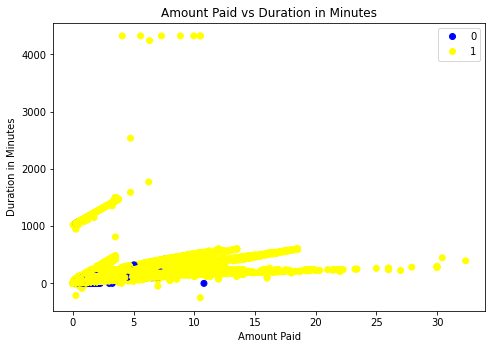

In [57]:
Meter_Transaction_Analysis_Pandas = Meter_Transaction_Analysis.toPandas()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

mydict = {0: 'blue',
          1: 'yellow'}

legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(mydict.values())]

ax.scatter(Meter_Transaction_Analysis_Pandas['Amount_Paid'], Meter_Transaction_Analysis_Pandas['Duration_In_Minutes'], c = Meter_Transaction_Analysis_Pandas['Payment_Mean'].map(mydict))
ax.set_xlabel('Amount Paid')
ax.set_ylabel('Duration in Minutes')
ax.set_title('Scatter Plot')
plt.title('Amount Paid vs Duration in Minutes')
ax.legend(legendhandle, list(mydict.keys()), loc = "upper right", frameon = True)
plt.show()

In [ ]:
# Logistic Regression

In [58]:
assembler = VectorAssembler(inputCols=['Amount_Paid', 'Duration_In_Minutes'],outputCol="features")
Meter_Transaction_Analysis = assembler.transform(Meter_Transaction_Analysis)

In [59]:
train, test = Meter_Transaction_Analysis.randomSplit([0.8, 0.2], seed = 777)
print("Training Dataset Count: " + str(train.count()))
print("Testing Dataset Count: " + str(test.count()))

train.groupby("Payment_Mean").count().show()
test.groupby("Payment_Mean").count().show()

Training Dataset Count: 104669
Testing Dataset Count: 26430
+------------+------+
|Payment_Mean| count|
+------------+------+
|           1|101678|
|           0|  2991|
+------------+------+

+------------+-----+
|Payment_Mean|count|
+------------+-----+
|           1|25689|
|           0|  741|
+------------+-----+



In [60]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
import time

start_train = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Payment_Mean', maxIter = 20)
lrModel = lr.fit(train)
end_train = time.time()

start_test = time.time()
lrpredictions = lrModel.transform(test)
end_test = time.time()

start_eval = time.time()
lrModel.evaluate(test)

lr_metrics = MulticlassMetrics(lrpredictions.select("Payment_Mean", "prediction").rdd.map(lambda x: (float(x[0]), float(x[1]))).cache())

precision = lr_metrics.precision(1.0)
recall = lr_metrics.recall(1.0)
f1Score = lr_metrics.fMeasure(1.0)

end_eval = time.time()
print("\nPerformance Metrics: Logisitic Regression")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1Score)
print("Confusion Matrix:", lr_metrics.confusionMatrix().toArray().astype(int))
print('The total time needed to train the model: {} secs\nEvaluate the model: {} secs\nTest the model: {} secs\nTotal Time: {} secs'.format(end_train - start_train,
                                                                                                                                            end_eval - start_eval,
                                                                                                                                            end_test - start_test,
                                                                                                                                            (end_train - start_train) + (end_eval - start_eval) + (end_test - start_test)))


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,



Performance Metrics: Logisitic Regression
Precision: 1.0
Recall: 0.9719636776390466
F1: 0.9857825361192656
Confusion Matrix: [[25689]]
The total time needed to train the model: 7.208588600158691 secs
Evaluate the model: 2.9375360012054443 secs
Test the model: 0.14087605476379395 secs
Total Time: 10.28700065612793 secs


In [61]:
lrModel.coefficientMatrix

DenseMatrix(1, 2, [0.3162, 0.0037], 1)

In [ ]:
# Linear SVC

In [63]:
from pyspark.ml.classification import LinearSVC

In [66]:
start_train = time.time()
lsvc = LinearSVC(featuresCol = 'features', labelCol = 'Payment_Mean', maxIter=20, regParam=0.1)

lsvcModel = lsvc.fit(train)

end_train = time.time()

start_test = time.time()
lsvc_predictions = lsvcModel.transform(test)
end_test = time.time()

start_eval = time.time()
lsvcModel.evaluate(test)

lsvc_metrics = MulticlassMetrics(lsvc_predictions.select("Payment_Mean", "prediction").rdd.map(lambda x: (float(x[0]), float(x[1]))).cache())

precision = lsvc_metrics.precision(1.0)
recall = lsvc_metrics.recall(1.0)
f1Score = lsvc_metrics.fMeasure(1.0)

end_eval = time.time()


print("\nPerformance Metrics: SVM")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1Score)
print("Confusion Matrix:", lsvc_metrics.confusionMatrix().toArray().astype(int))
print('The total time needed to train the model: {} secs\nEvaluate the model: {} secs\nTest the model: {} secs\nTotal Time: {} secs'.format(end_train - start_train,
                                                                                                                                            end_eval - start_eval,
                                                                                                                                            end_test - start_test,
                                                                                                                                            (end_train - start_train) + (end_eval - start_eval) + (end_test - start_test)))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,



Performance Metrics: SVM
Precision: 1.0
Recall: 0.9719636776390466
F1: 0.9857825361192656
Confusion Matrix: [[25689]]
The total time needed to train the model: 11.870356321334839 secs
Evaluate the model: 2.4445691108703613 secs
Test the model: 0.05910229682922363 secs
Total Time: 14.374027729034424 secs
